# Lab | Text Generation from Shakespeare's Sonnet

This notebook explores the fascinating domain of text generation using a deep learning model trained on Shakespeare's sonnets. 

The objective is to create a neural network capable of generating text sequences that mimic the style and language of Shakespeare.

By utilizing a Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM) layers, this project aims to demonstrate how a model can learn and replicate the complex patterns of early modern English. 

The dataset used consists of Shakespeare's sonnets, which are preprocessed and tokenized to serve as input for the model.

Throughout this notebook, you will see the steps taken to prepare the data, build and train the model, and evaluate its performance in generating text. 

This lab provides a hands-on approach to understanding the intricacies of natural language processing (NLP) and the potential of machine learning in creative text generation.

Let's import necessary libraries

In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np

Let's get the data!

In [2]:
import requests
url = 'https://raw.githubusercontent.com/martin-gorner/tensorflow-rnn-shakespeare/master/shakespeare/sonnets.txt'
resp = requests.get(url)
with open('sonnets.txt', 'wb') as f:
    f.write(resp.content)

data = open('sonnets.txt').read()

corpus = data.lower().split("\n")

Step 1: Initialise a tokenizer and fit it on the corpus variable using .fit_on_texts

In [3]:
# Initialize the tokenizer
tokenizer = Tokenizer()

# Fit the tokenizer on the corpus
tokenizer.fit_on_texts(corpus)

Step 2: Calculate the Vocabulary Size

Let's figure out how many unique words are in your corpus. This will be the size of your vocabulary.

Calculate the length of tokenizer.word_index, add 1 to it and store it in a variable called total_words.

In [4]:
# Calculate vocabulary size
total_words = len(tokenizer.word_index) + 1
print(f"Total unique words: {total_words}")

Total unique words: 3375


Create an empty list called input_sequences.

For each sentence in your corpus, convert the text into a sequence of integers using the tokenizer.
Then, generate n-gram sequences from these tokens.

Store the result in the list input_sequences.

In [5]:
# Create input sequences
input_sequences = []

for line in corpus:
    # Convert the line of text into a sequence of integers
    token_list = tokenizer.texts_to_sequences([line])[0]
    
    # Create n-grams
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# Veamos algunas secuencias originales
print("Primeras 3 secuencias antes del padding:")
for seq in input_sequences[:3]:
    print(seq)

Primeras 3 secuencias antes del padding:
[3, 2]
[3, 2, 313]
[3, 2, 313, 1375]


Calculate the length of the longest sequence in input_sequences. Assign the result to a variable called max_sequence_len.

Now pad the sequences using pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre').
Convert it to a numpy array and assign the result back to our variable called input_sequences.

In [6]:
# Find the length of the longest sequence
max_sequence_len = max([len(x) for x in input_sequences])
print(f"\nLongitud máxima de secuencia: {max_sequence_len}")

# Pad sequences to make them all the same length
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')
print("\nPrimeras 3 secuencias después del padding:")
for seq in input_sequences[:3]:
    print(seq)

# Para ver las palabras reales, podemos decodificar una secuencia
print("\nEjemplo decodificado:")
# Creamos un diccionario inverso para convertir números a palabras
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
def sequence_to_text(sequence):
    return ' '.join(reverse_word_map.get(i, '?') for i in sequence if i != 0)

print("Secuencia numérica:", input_sequences[0])
print("Texto decodificado:", sequence_to_text(input_sequences[0]))


Longitud máxima de secuencia: 11

Primeras 3 secuencias después del padding:
[0 0 0 0 0 0 0 0 0 3 2]
[  0   0   0   0   0   0   0   0   3   2 313]
[   0    0    0    0    0    0    0    3    2  313 1375]

Ejemplo decodificado:
Secuencia numérica: [0 0 0 0 0 0 0 0 0 3 2]
Texto decodificado: to the


Prepare Predictors and Labels

Split the sequences into two parts:

- Predictors: All elements from input_sequences except the last one.
- Labels: The last element of each sequence in input_sequences.

In [7]:
# Split sequences into input and output
predictors = input_sequences[:, :-1]
labels = input_sequences[:, -1]

print("\nForma de los predictores:", predictors.shape)
print("Forma de las etiquetas:", labels.shape)

print("\nEjemplo de predictor y etiqueta:")
print("Predictor:", sequence_to_text(predictors[0]))
print("Etiqueta:", sequence_to_text([labels[0]]))


Forma de los predictores: (15484, 10)
Forma de las etiquetas: (15484,)

Ejemplo de predictor y etiqueta:
Predictor: to
Etiqueta: the


One-Hot Encode the Labels :

Convert the labels (which are integers) into one-hot encoded vectors. 

Ensure the length of these vectors matches the total number of unique words in your vocabulary.

Use ku.to_categorical() on labels with num_classes = total_words

Assign the result back to our variable labels.

In [8]:
# One-hot encode the labels
labels = ku.to_categorical(labels, num_classes=total_words)

print("Forma de las etiquetas después de one-hot encoding:", labels.shape)
print("\nEjemplo de una etiqueta one-hot:")
print("Índice original:", np.argmax(labels[0]))
print("Vector one-hot:", labels[0][:10], "...") # Mostramos solo los primeros 10 valores

Forma de las etiquetas después de one-hot encoding: (15484, 3375)

Ejemplo de una etiqueta one-hot:
Índice original: 2
Vector one-hot: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.] ...


# Initialize the Model

Start by creating a Sequential model.

Add Layers to the Model:

Embedding Layer: The first layer is an embedding layer. It converts word indices into dense vectors of fixed size (100 in this case). Set the input length to the maximum sequence length minus one, which corresponds to the number of previous words the model will consider when predicting the next word.

Bidirectional LSTM Layer: Add a Bidirectional LSTM layer with 150 units. This layer allows the model to learn context from both directions (past and future) in the sequence. return_sequences=True

Dropout Layer: Add a dropout layer with a rate of 0.2 to prevent overfitting by randomly setting 20% of the input units to 0 during training.

LSTM Layer: Add a second LSTM layer with 100 units. This layer processes the sequence and passes its output to the next layer.

Dense Layer (Intermediate): Add a dense layer with half the total number of words as units, using ReLU activation. A regularization term (L2) is added to prevent overfitting.

Dense Layer (Output): The final dense layer has as many units as there are words in the vocabulary, with a softmax activation function to output a probability distribution over all words.

In [9]:
model = Sequential([
    # Capa de Embedding: convierte índices de palabras en vectores densos
    Embedding(input_dim=total_words, output_dim=100),
    
    # Primera capa LSTM bidireccional
    Bidirectional(LSTM(150, return_sequences=True)),
    Dropout(0.2),
    
    # Segunda capa LSTM
    LSTM(100),
    
    # Capa densa intermedia con regularización
    Dense(total_words//2, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    
    # Capa de salida
    Dense(total_words, activation='softmax')
])


2025-01-08 11:57:09.064563: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-01-08 11:57:09.064580: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-01-08 11:57:09.064585: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-01-08 11:57:09.064766: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-08 11:57:09.064776: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Compile the Model:

Compile the model using categorical crossentropy as the loss function, the Adam optimizer for efficient training, and accuracy as the metric to evaluate during training.

In [10]:
# Compilar el modelo
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

print("Configuración del modelo:")
print("- Loss function: Categorical Crossentropy")
print("- Optimizer: Adam (learning rate = 0.001)")
print("- Metrics: Accuracy")

# Construir el modelo con las dimensiones de los datos
model.build(input_shape=(None, max_sequence_len-1))

Configuración del modelo:
- Loss function: Categorical Crossentropy
- Optimizer: Adam (learning rate = 0.001)
- Metrics: Accuracy


# Print Model Summary:

Use model.summary() to print a summary of the model, which shows the layers, their output shapes, and the number of parameters.

In [11]:
# Imprimir resumen del modelo
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 10, 100)        │       337,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 10, 300)        │       301,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │       160,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1687)           │       170,387 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3375)           │     5,697,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,666,487 (25.43 MB)

 Trainable params: 6,666,487 (25.43 MB)

 Non-trainable params: 0 (0.00 B)

# Now train the model for 50 epochs and assign it to a variable called history.

Training the model with 50 epochs should get you around 40% accuracy.

You can train the model for as many epochs as you like depending on the time and computing constraints you are facing. Ideally train it for a larger amount of epochs than 50.

That way you will get better text generation at the end.

However, dont waste your time.

In [12]:
# Entrenar el modelo
history = model.fit(
    predictors,
    labels,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    verbose=1
)

print("\nResumen del entrenamiento:")
print(f"Épocas completadas: {len(history.history['loss'])}")
print(f"Accuracy final: {history.history['accuracy'][-1]:.4f}")
print(f"Loss final: {history.history['loss'][-1]:.4f}")

Epoch 1/50


2025-01-08 11:57:09.861447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


109/109 ━━━━━━━━━━━━━━━━━━━━ 23s 181ms/step - accuracy: 0.0213 - loss: 8.0441 - val_accuracy: 0.0123 - val_loss: 6.9031
Epoch 2/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 18s 168ms/step - accuracy: 0.0262 - loss: 6.5399 - val_accuracy: 0.0219 - val_loss: 6.9661
Epoch 3/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 18s 167ms/step - accuracy: 0.0209 - loss: 6.4717 - val_accuracy: 0.0226 - val_loss: 7.0625
Epoch 4/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 18s 167ms/step - accuracy: 0.0229 - loss: 6.3531 - val_accuracy: 0.0252 - val_loss: 7.0235
Epoch 5/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 18s 168ms/step - accuracy: 0.0324 - loss: 6.2508 - val_accuracy: 0.0252 - val_loss: 7.1756
Epoch 6/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 18s 169ms/step - accuracy: 0.0345 - loss: 6.1804 - val_accuracy: 0.0245 - val_loss: 7.1482
Epoch 7/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 19s 177ms/step - accuracy: 0.0364 - loss: 6.0988 - val_accuracy: 0.0239 - val_loss: 7.1479
Epoch 8/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 18s 169ms/step - accuracy: 0.0374 - loss: 6.0433 - val

# Use plt from matplotlib to plot the training accuracy over epochs and the loss over epochs

First you will have to get the accuracy and loss data over epochs, you can do this by using methods on your model.

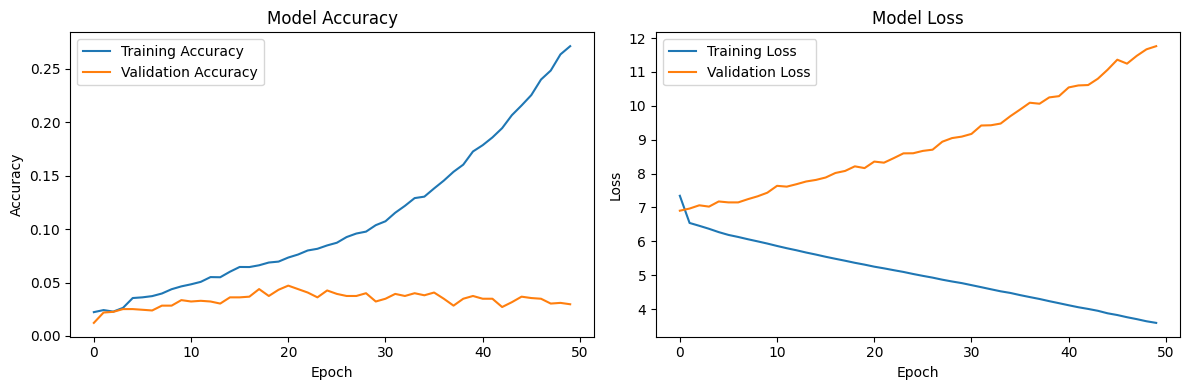

In [17]:
import matplotlib.pyplot as plt

# Graficar el historial de entrenamiento
plt.figure(figsize=(12, 4))

# Subplot para accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Subplot para loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Generate text with the model based on a seed text

Now you will create two variables :

- seed_text = 'Write the text you want the model to use as a starting point to generate the next words'
- next_words = number_of_words_you_want_the_model_to_generate

Please change number_of_words_you_want_the_model_to_generate by an actual integer.

In [18]:
# Definir función para generar texto
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        # Tokenizar el texto semilla
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        # Padding
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        # Predecir
        predicted = model.predict(token_list, verbose=0)
        # Obtener el índice de la palabra con mayor probabilidad
        predicted = np.argmax(predicted, axis=-1)
        # Convertir el índice a palabra
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        # Añadir la palabra al texto semilla
        seed_text += " " + output_word
    return seed_text

# Probar la generación
seed_text = "shall i compare thee to"
next_words = 20

print("Texto generado:")
print(generate_text(seed_text, next_words, model, max_sequence_len))

Texto generado:
shall i compare thee to my love of men ' write to me prove thee my report state truth ' lie to thee shines none


Now create a loop that runs based on the next_words variable and generates new text based on your seed_text input string. Print the full text with the generated text at the end.

This time you dont get detailed instructions.

Have fun!

In [19]:
# Probar diferentes semillas de texto
seed_texts = [
    "shall i compare thee to",
    "my love is like a",
    "when in disgrace with fortune"
]

print("Generando diferentes textos:\n")
for seed in seed_texts:
    print(f"Semilla: '{seed}'")
    generated = generate_text(seed, next_words=20, model=model, max_sequence_len=max_sequence_len)
    print(f"Resultado: {generated}\n")

Generando diferentes textos:

Semilla: 'shall i compare thee to'
Resultado: shall i compare thee to my love of men ' write to me prove thee my report state truth ' lie to thee shines none

Semilla: 'my love is like a'
Resultado: my love is like a stage starved yet to me be none dead hate dwell say lie alone to me more are old more report

Semilla: 'when in disgrace with fortune'
Resultado: when in disgrace with fortune and lend me eye do show me say shines art time say such tend respect lie to me prove me



Experiment with at least 3 different seed_text strings and see what happens!

In [20]:
def generate_shakespeare(seed_text, num_words=20):
    """
    Función interactiva para generar texto estilo Shakespeare
    """
    print(f"\nGenerando {num_words} palabras a partir de: '{seed_text}'")
    result = generate_text(seed_text, num_words, model, max_sequence_len)
    print("\nTexto generado:")
    print(result)
    return result

# Ejemplos de uso con diferentes longitudes
print("Experimento 1: Texto corto")
generate_shakespeare("love is", 10)

print("\nExperimento 2: Texto medio")
generate_shakespeare("the world is", 15)

print("\nExperimento 3: Texto largo")
generate_shakespeare("in the summer's day", 25)

Experimento 1: Texto corto

Generando 10 palabras a partir de: 'love is'

Texto generado:
love is my heart in thy sake phoenix and such green thee

Experimento 2: Texto medio

Generando 15 palabras a partir de: 'the world is'

Texto generado:
the world is found in a dream doth part ' none often of thee men lie ' are

Experimento 3: Texto largo

Generando 25 palabras a partir de: 'in the summer's day'

Texto generado:
in the summer's day is lost in my love of me uphold ride grow men ' none made me lie of men too report lie by thee green me


"in the summer's day is lost in my love of me uphold ride grow men ' none made me lie of men too report lie by thee green me"